## Problem: Connectivity Map
The Connectivity Map (CMap) is a Broad Institute project that enables the discovery of functional connections between drugs, genes and diseases through the generation and analysis of gene expression signatures (see the papers in Science and Nature Reviews Cancer). Recent technological advances and laboratory automation have enabled data generation scale-up resulting in a massive catalog of drug and gene signatures. When coupled with powerful pattern recognition algorithms, these data represent a rich reference library for the research community.

### Problem Description
* Every sample contains 12,320 gene expression levels that include 970 landmarks and 11,350 non-landmark genes.
* Training dataset: 100,000 samples (~2GB data)
* Testing dataset: 1,000 samples.
* Problem: To build a model that uses the 970 landmark genes to predict the expression levels of non-landmark genes.

[Link to the TC contest: Connectivity Map](https://community.topcoder.com/longcontest/?module=ViewProblemStatement&rd=16753&pm=14337)

### Data Format
* Data is provided as CSV files where the rows correspond to genes and the columns correspond to samples.
* The matrix values are floating point numbers in the range 0.00 to 15.00.

The first few rows and columns of one such file is shown below.

6.85,4.78,7.83,8.37,4.57,10.91,14.55,8.24,6.23,8.43,10.14,8.21,8.15,7.29,13.07,9.86,9.86,5.44
7.98,11.37,8.1,7.19,5.52,7.99,10.41,8.09,6.8,9.24,8.81,8.67,8.29,8.49,10.52,9.71,9,6.46,8.37,6.73
5.68,4.27,7.49,8.44,5.18,7.17,9.24,7.81,4.59,7.76,9.08,5.94,7.43,7.86,8.04,9.22,10.08,7.14,6.91
9.52,7.82,9.2,7.03,5.42,8.11,10.05,7.98,6.95,7.96,11.91,7.62,8.62,8.27,10.6,8.4,8.42,6.64,9.26,7.11
6.37,4.42,10.31,8,6.49,6.19,11.17,7.11,6.61,6.8,10.71,4.62,4.43,9.38,7.78,11.34,7.7,5.83,7.56,7.22
9.56,6.27,8.94,6.27,7.47,7.77,8.38,12.45,7.03,6.31,7.27,4.22,10.74,10.91,8.65,4.47,6.51,7.87,7.24
6.68,10.56,8.7,7.95,5.97,6.92,9.67,9.36,7.95,8.1,8.64,10.11,4.42,10.99,9.62,6.21,7.18,7.74,10,7.28
10.54,5.66,8.61,6.38,6.13,9.61,7.28,8.76,7.62,6.67,12.58,6.81,6.18,8.91,9.37,7.01,7.02,8.68,12.93
7.08,4.74,8.64,7.72,5.59,7.73,9.99,6.93,6.36,7.38,8.87,7.5,7.72,9.12,11.32,7.84,8.34,6.26,9.04,6.25
7.79,6.84,8.51,6.76,6.09,7.72,9.64,7.92,5.96,6.81,10.68,6.08,9.11,7.97,10,8.94,7.33,6.47,8.03,7.06

In [68]:
import numpy as np
import scipy as sp
import scipy.stats.mstats

import sklearn.ensemble as ens
import sklearn.metrics as ms
import sklearn.neural_network as nn
import sklearn.svm as svm

from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab

#### Loading and shuffling the training data

In [ ]:
original = np.loadtxt('training.tsv', dtype=np.float32)
original = original.transpose()

In [ ]:
data = np.copy(original)
np.random.shuffle(data)

#### Normalizing data by standard score

In [ ]:
data = np.apply_along_axis(lambda x: (x - np.mean(x)) / np.std(x), 0, data)

#### Split data into train and test subsets

In [28]:
thres = round(len(data) * 0.7)

train = data[:thres]
test = data[thres:]

print("Train:" + str(train.shape))
print("Test: " + str(test.shape))

Train:(70000, 12320)
Test: (30000, 12320)


#### Drawing PDF of the most bad (residual sum of squares) gene distribution

0.208545635784


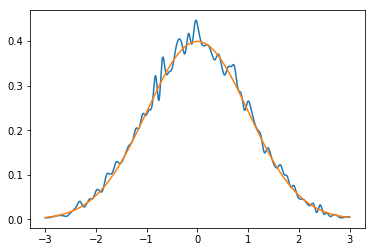

In [121]:
def makeF(sample):
    n = len(sample) // 100
    s = np.random.normal(size=len(sample))   # generate your data sample with N elements
    p, x = np.histogram(s, bins=n) # bin it into n = N/10 bins
    x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
    f = UnivariateSpline(x, p, s=n)
    k = 0.0
    xs = np.linspace(-3, 3, 1000)
    for y in xs:
        k += (f(y) / mlab.normpdf(y, 0, 1))
    k /= 1000
    g = lambda x: f(x) / k
    return g
    
def plotDensity(sample):
    f = makeF(sample)
    x = np.linspace(-3, 3, 1000)
    plt.plot(x, f(x))
    plt.plot(x,mlab.normpdf(x, 0, 1))
    plt.show()

def score(sample):
    f = makeF(sample)
    xs = np.linspace(-3, 3, 1000)
    score = 0.0
    for x in xs:
        score += (f(x) - mlab.normpdf(x, 0, 1)) ** 2
    return score

bad = max(data[:1000], key=score)
print(score(bad))
plotDensity(bad)

## Glance at the data

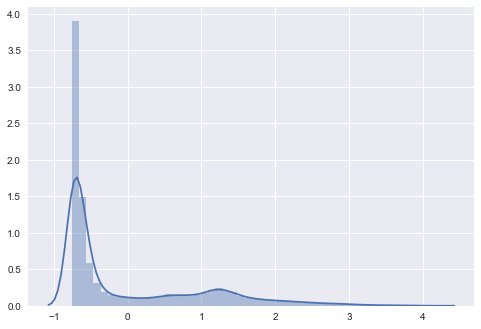

In [53]:
sns.distplot(data.T[1])
plt.show()

#### Find dependencies using RF feature selection

In [91]:
first_label = 970
reg = ens.RandomForestRegressor(100, max_depth= 10, n_jobs=6)
reg.fit(data[:, :first_label], data[:, first_label])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=6, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [98]:
sign_feature = max(enumerate(reg.feature_importances_), key=(lambda x: x[1]))[0]

#### Joint distribution of dependent features

In [138]:
sample  = pd.DataFrame(data=np.vstack((data[:, sign_feature], data[:, first_label])))
sample = sample.T

In [139]:
sample = sample.sample(frac=0.1)

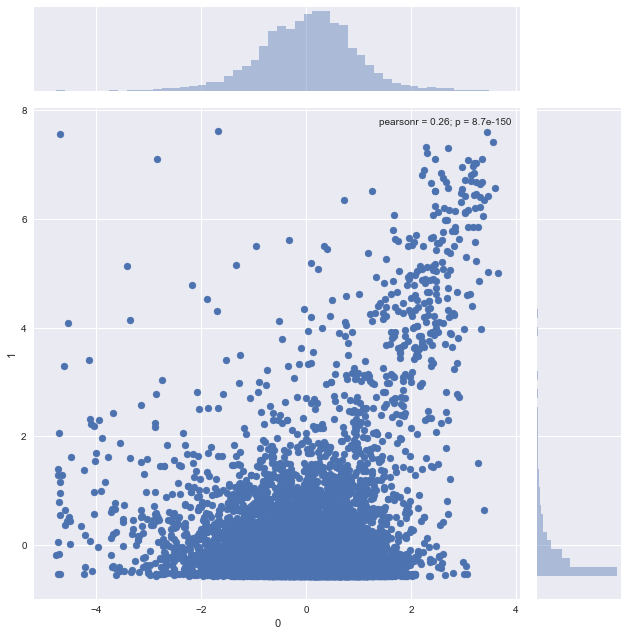

In [140]:
sns.jointplot(x = 0, y = 1, data = sample, size = 9)
plt.show()

#### Copula

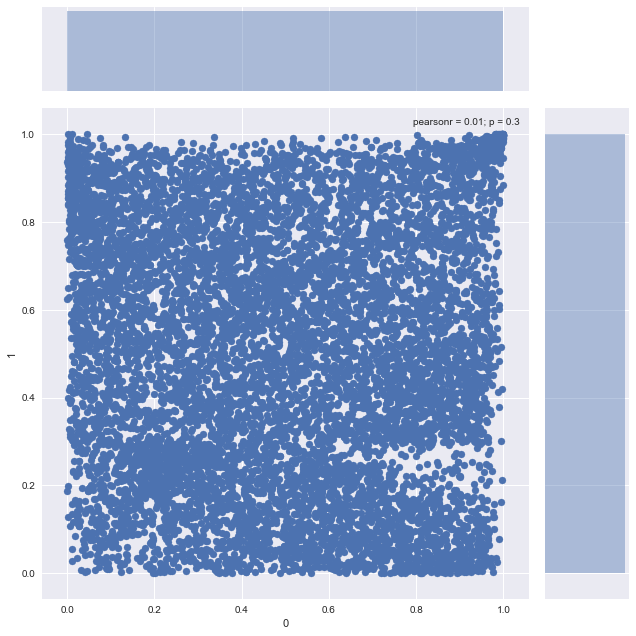

In [144]:
ranks = sample.rank(method='first', pct=True)
sns.jointplot(x = 0, y = 1, data = ranks, size = 9)
plt.show()

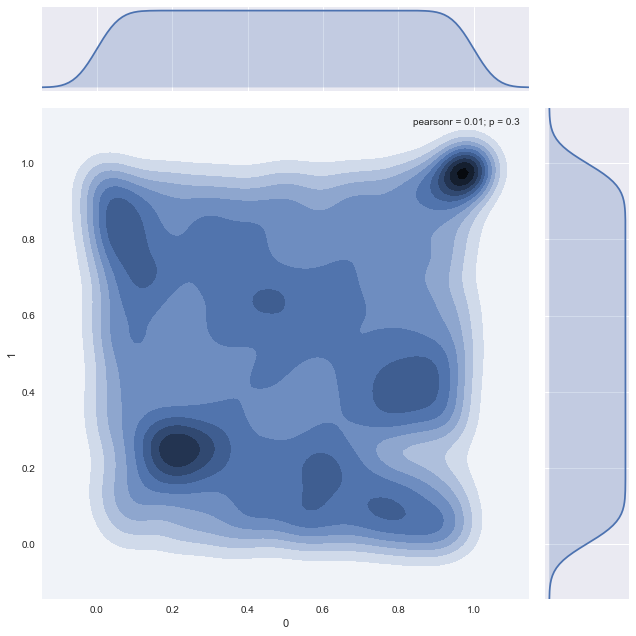

In [146]:
ranks = sample.rank(method='first', pct=True)
sns.jointplot(x = 0, y = 1, data = ranks, size = 9, kind="kde")
plt.show()

#### Preparing train and test data

In [29]:
landmark_genes = 970
lset = list(range(landmark_genes))
nlset = list(range(landmark_genes, data.shape[1]))
print("Number of landmark genes: " + str(len(lset)))
print("Number of non-landmark genes: " + str(len(nlset)))

Number of landmark genes: 970
Number of non-landmark genes: 11350


In [30]:
train = (train[:, lset], train[:, nlset])
test = (test[:, lset], test[:, nlset])
print("Features shape: " + str(train[0].shape))
print("Output shape" + str(train[1].shape))

Features shape: (70000, 970)
Output shape(70000, 11350)


### Running random forest algorithm

In [37]:
reg = ens.RandomForestRegressor(100, max_depth= 10, n_jobs=6, verbose=10)

In [38]:
reg.fit(train[0], train[1][:, 0])

building tree 1 of 100building tree 2 of 100building tree 4 of 100building tree 5 of 100building tree 3 of 100building tree 6 of 100





building tree 7 of 100


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   37.4s


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   40.0s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.9min


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  2.5min


building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  3.2min


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.5min


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  5.7min


building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  6.5min


building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  8.3min


building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  9.7min


building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed: 10.9min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=6, oob_score=False, random_state=None,
           verbose=10, warm_start=False)

In [53]:
print("Test: " + str(ms.mean_squared_error(reg.predict(test[0]), test[1][:, 0])))
print("Train: " + str(ms.mean_squared_error(reg.predict(train[0]), train[1][:, 0])))

[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.2s finished


Test: 0.255106343803


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:    0.4s


Train: 0.188591014594


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.5s finished


### Runnning  Multi-layer Perceptron with two hidden layers.

In [49]:
mlp = nn.MLPRegressor((500, 500), verbose=True)

In [50]:
mlp.fit(train[0], train[1][:, 0])

Iteration 1, loss = 0.15734467
Iteration 2, loss = 0.09699614
Iteration 3, loss = 0.08017809
Iteration 4, loss = 0.07036193
Iteration 5, loss = 0.06462790
Iteration 6, loss = 0.06062630
Iteration 7, loss = 0.05451479
Iteration 8, loss = 0.05125728
Iteration 9, loss = 0.04744551
Iteration 10, loss = 0.04417707
Iteration 11, loss = 0.04312625
Iteration 12, loss = 0.04070614
Iteration 13, loss = 0.03834889
Iteration 14, loss = 0.03652559
Iteration 15, loss = 0.03644094
Iteration 16, loss = 0.03366137
Iteration 17, loss = 0.03347860
Iteration 18, loss = 0.03187227
Iteration 19, loss = 0.02999984
Iteration 20, loss = 0.03001545
Iteration 21, loss = 0.02880777
Iteration 22, loss = 0.02720759
Iteration 23, loss = 0.02723549
Iteration 24, loss = 0.02547442
Iteration 25, loss = 0.02468821
Iteration 26, loss = 0.02442430
Iteration 27, loss = 0.02555776
Iteration 28, loss = 0.02372905
Iteration 29, loss = 0.02193370
Iteration 30, loss = 0.02174861
Iteration 31, loss = 0.02078453
Iteration 32, los

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(500, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [52]:
print("Test: " + str(ms.mean_squared_error(mlp.predict(test[0]), test[1][:, 0])))
print("Train: " + str(ms.mean_squared_error(mlp.predict(train[0]), train[1][:, 0])))

Test: 0.182695103441
Train: 0.0263513249707


### Running Support Vector Machine

In [46]:
svr = svm.SVR(verbose=True)

In [47]:
svr.fit(train[0], train[1][:, 0])

[LibSVM]

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=True)

In [54]:
print("Test: " + str(ms.mean_squared_error(svr.predict(test[0]), test[1][:, 0])))
print("Train: " + str(ms.mean_squared_error(svr.predict(train[0]), train[1][:, 0])))

Test: 0.197507087844
Train: 0.113986677183


### Conclusion:
* MLP shows best scores among three methods.
* Even test score of MLP method shows better results than train score of Random Forest algorithm.
* MLP is overfitted on train data.